In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

In [2]:
import pandas as pd
import numpy as np
import src.data.NHLDataManager as DataManager
data_manager = DataManager.NHLDataManager()

In [3]:
# shot_types = ['Tip-In', 'Wrist Shot', 'Snap Shot', 'Backhand', 'Slap Shot']
# game_numbers = data_manager.get_game_numbers(2018, "Regular")
# goals_and_shots = pd.DataFrame()
# for game in game_numbers:
#     goals_and_shots = pd.concat([goals_and_shots, data_manager.get_goals_and_shots_df(2018, "Regular", game)[["Type", "Shot Type"]]])
# goals_and_shots.head()

shot_types = ['Tip-In', 'Wrist Shot', 'Snap Shot', 'Backhand', 'Slap Shot']

season_year = 2018
season_type = "Regular"
data_season_df = data_manager.get_season_dataframe(season_year=season_year, season_type=season_type)

goals_and_shots = data_season_df[["Type", "Shot Type"]]
goals_and_shots = goals_and_shots[goals_and_shots["Shot Type"].isin(shot_types)].dropna()

In [4]:
# data_season_df.loc[data_season_df['Empty Net'] == True]

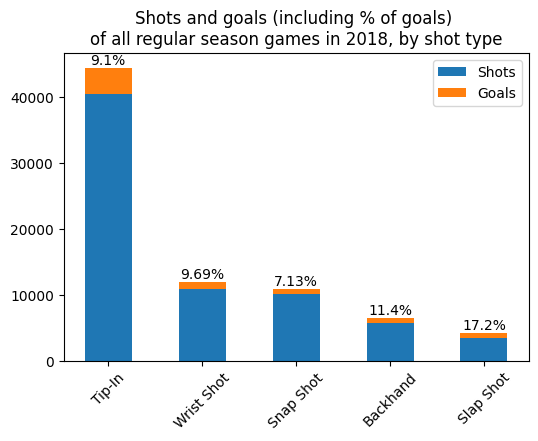

In [5]:
# Q1

import matplotlib.pyplot as plt
from collections import Counter

# filter out NaN values
goals_and_shots = goals_and_shots.dropna()
labels = shot_types

# Grab counts
shots = goals_and_shots[goals_and_shots["Type"] == "Shot"]
goals = goals_and_shots[goals_and_shots["Type"] == "Goal"]
shot_counts = Counter(shots["Shot Type"])
goal_counts = Counter(goals["Shot Type"])
shot_counts_filtered = []
goal_counts_filtered = []
for l in labels:
    shot_counts_filtered.append(shot_counts[l])
    goal_counts_filtered.append(goal_counts[l])

shot_counts_filtered = np.sort(np.array(shot_counts_filtered))[::-1]
goal_counts_filtered = np.sort(np.array(goal_counts_filtered))[::-1]
    

fig, ax = plt.subplots(figsize=(6, 4))
p1 = ax.bar(labels, shot_counts_filtered, width=0.5, label='Shots')
p2 = ax.bar(labels, goal_counts_filtered, width=0.5, bottom=shot_counts_filtered, label='Goals')
goal_percent_by_shot_type = [(goal_counts_filtered[i]/(shot_counts_filtered[i]+goal_counts_filtered[i]))*100 for i in range(len(labels))]
plt.bar_label(p2, labels=[f"{p:.3}%" for p in goal_percent_by_shot_type])
plt.xticks(rotation=45)
plt.title(f"Shots and goals (including % of goals) \nof all {season_type.lower()} season games in {season_year}, by shot type")
plt.legend()
plt.savefig('../../../blogpost/Q4_1.png', bbox_inches="tight")

In [6]:
from tqdm.auto import tqdm

# Q2
shots_by_season = []
skipped = 0
for season in [2018, 2019, 2020]:
    for season_type in ("Regular", "Playoffs"):
        distance_data = pd.DataFrame()
        game_numbers = data_manager.get_game_numbers(season, season_type)
        for game in tqdm(game_numbers):
            try:
                distance_data = pd.concat([distance_data, data_manager.get_goals_and_shots_df_standardised(season, season_type, game)[["Type", "Shot Type", "st_X", "st_Y", "Empty Net"]]])
            except:
                # Sometimes the rinkSide isn't provided...
                # For now we could skip it?
                skipped += 1
                continue
        shots_by_season.append(distance_data)
print(f"Skipped games: {skipped}")

  0%|          | 0/1271 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/1271 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/1271 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

Skipped games: 779


In [11]:
import matplotlib.pyplot as plt
import numpy as np

distances_by_season = []

for season in shots_by_season:
    season['Empty Net'] = season["Empty Net"].fillna(False)
    season = season.dropna()
    distance = np.linalg.norm((season.iloc[:,2:4] - np.array([89,0])).astype(float), axis=1) # Goal is located at (89, 0)
    df = pd.DataFrame()
    df['Type'] = season.Type
    df['distance'] = distance
    distances_by_season.append(df)

In [12]:
df.head(10)

,Type,distance
0,Goal,38.600518
1,Goal,27.856777
2,Goal,25.298221
3,Goal,40.311289
4,Goal,37.215588
5,Goal,29.427878
6,Goal,15.000000
7,Shot,10.770330
8,Shot,74.040529
9,Shot,28.160256


In [13]:
for season in distances_by_season:
    print(season.distance.min(), season.distance.max())

1.0 189.6549498431296
3.0 187.6725872363889
1.4142135623730951 188.0239346466295
2.23606797749979 187.52333188166213
1.0 188.0239346466295
1.4142135623730951 185.3887806745597


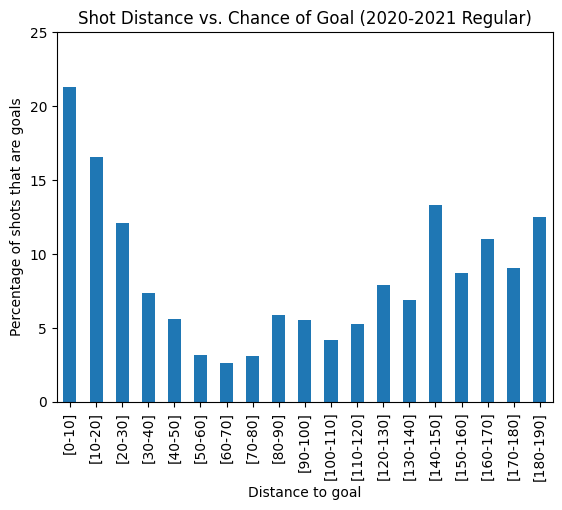

In [15]:
i = 0
for s in [2018, 2019, 2020]:
    # season_types = ("Regular", "Playoffs")
    season_types = ["Regular"]
    for season_type in season_types:
        season = distances_by_season[i]
        shots = season[season.Type == 'Shot'].distance
        goals = season[season.Type == 'Goal'].distance
        bins = [i*10 for i in range(20)]
        bin_labels = [f"[{i*10}-{(i+1)*10}]" for i in range(19)]
        shots_bins = pd.cut(shots, bins=bins, labels=bin_labels).value_counts(sort=False)
        goals_bins = pd.cut(goals, bins=bins, labels=bin_labels).value_counts(sort=False)
        goal_percent = (goals_bins / (shots_bins + goals_bins)) * 100
        goal_percent.plot.bar()
        plt.ylim(0, 25)
        plt.xlabel("Distance to goal")
        plt.ylabel("Percentage of shots that are goals")
        plt.title(f"Shot Distance vs. Chance of Goal ({s}-{s+1} {season_type})")
        plt.savefig(f"../../blogpost/Q4_2_{s}_{s+1}.png", bbox_inches="tight")
        i += 1

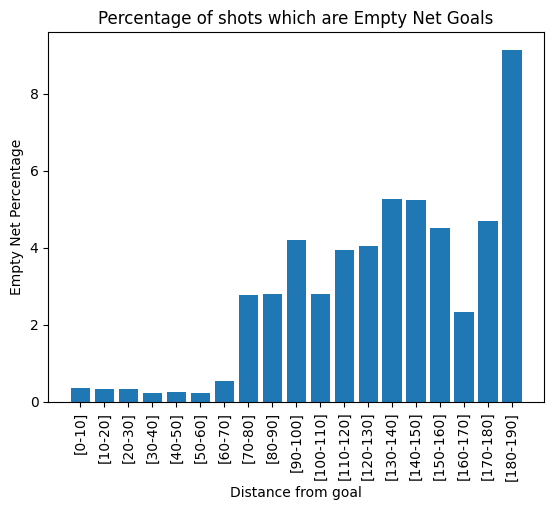

In [16]:
# Empty net percentage graph
distances = distances_by_season[0]
empty_net = shots_by_season[0].dropna()['Empty Net']

binned_distances = pd.DataFrame(pd.cut(distances.distance, bins=bins, labels=bin_labels))
binned_distances["empty_net"] = empty_net
grouped = binned_distances.groupby('distance').value_counts()

ratio = []
for b in bin_labels:
    denom = grouped[b].sum()
    num = grouped[b, True]
    ratio.append((num / denom) * 100)
    
plt.bar(bin_labels, ratio)
plt.xticks(rotation=90)
plt.xlabel("Distance from goal")
plt.ylabel("Empty Net Percentage")
plt.title("Percentage of shots which are Empty Net Goals")
plt.savefig("../../blogpost/Q4_2-EmptyNet.png", bbox_inches="tight")

In [23]:
df

,Type,Shot Type,st_X,st_Y,Empty Net,distance
0,Goal,Wrap-around,87.0,-3.0,False,3.605551
1,Goal,Snap Shot,64.0,14.0,False,28.653098
2,Goal,Snap Shot,63.0,5.0,False,26.476405
3,Goal,Slap Shot,53.0,-7.0,False,36.674242
4,Goal,Snap Shot,74.0,4.0,False,15.524175
...,...,...,...,...,...,...
55,Shot,Wrist Shot,60.0,-16.0,False,33.120990
56,Shot,Slap Shot,67.0,-19.0,False,29.068884
57,Shot,Wrist Shot,78.0,-1.0,False,11.045361
58,Shot,Wrist Shot,82.0,-10.0,False,12.206556


In [24]:
# Q3
bins = [i*10 for i in range(20)]
bin_labels = [f"[{i*10}-{(i+1)*10}]" for i in range(19)]

df = shots_by_season[0].dropna().copy()
df['distance'] = distances_by_season[0].distance
df['distance_bin'] = pd.cut(df.distance, bins=bins, labels=bin_labels)
df = df.drop(labels=['st_X', 'st_Y', 'distance', 'Empty Net'], axis=1)
df

,Type,Shot Type,distance_bin
0,Goal,Wrap-around,[0-10]
1,Goal,Snap Shot,[20-30]
2,Goal,Snap Shot,[20-30]
3,Goal,Slap Shot,[30-40]
4,Goal,Snap Shot,[10-20]
...,...,...,...
55,Shot,Wrist Shot,[30-40]
56,Shot,Slap Shot,[20-30]
57,Shot,Wrist Shot,[10-20]
58,Shot,Wrist Shot,[10-20]


In [32]:
import math
heatmap_data = np.zeros((len(bin_labels), len(labels)))
groups = df.groupby(['Shot Type', 'distance_bin']).value_counts()
for i, bin_label in enumerate(bin_labels):
    for j, shot_type in enumerate(labels):
        group = groups[shot_type, bin_label]
        
        if (group.sum() * 100 != 0)
            goal_percent = group['Goal'] / group.sum() * 100
            heatmap_data[i,j] = goal_percent
            # heatmap_data[i,j] = goal_percent if not math.isnan(goal_percent) else 0
heatmap_data = pd.DataFrame(heatmap_data)
heatmap_data.columns = labels
heatmap_data.index = bin_labels

109500.0
330200.0
32000.0
162000.0
8800.0
222900.0
821800.0
158300.0
280200.0
24000.0
41200.0
741000.0
235700.0
89100.0
67000.0
6300.0
765600.0
268200.0
42000.0
161900.0
4200.0
629500.0
194500.0
17000.0
254300.0
5400.0
501900.0
137000.0
7600.0
428200.0
8600.0
195100.0
47000.0
4500.0
138700.0
5600.0
59700.0
7200.0
7200.0
11400.0
3000.0
48500.0
4400.0
4900.0
12400.0
2100.0
28600.0
3200.0
3200.0
5700.0
700.0
17700.0
2200.0
1900.0
1900.0
600.0
10800.0
1700.0
900.0
1100.0
800.0
15600.0
1900.0
1000.0
2900.0
100.0
18000.0
2200.0
1300.0
3000.0
200.0
19100.0
1000.0
1400.0
2700.0
0.0


RuntimeWarning: invalid value encountered in long_scalars

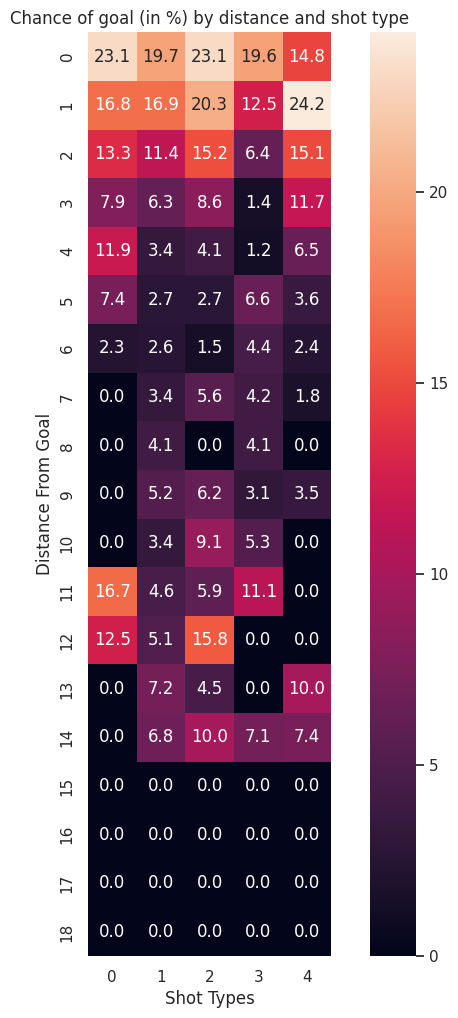

In [26]:
import seaborn as sns
sns.set(rc={"figure.figsize":(10, 12)})
plt.title("Chance of goal (in %) by distance and shot type")
h = sns.heatmap(heatmap_data, square=True, annot=True, fmt=".1f")
h.set(xlabel="Shot Types", ylabel="Distance From Goal")
plt.savefig("../../blogpost/Q4_3.png", bbox_inches="tight")